# Aufgabe 2 - Tiefe Einblicke ins Institut

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

## Teilaufgabe a): Trainings-und Testdatenset

In [1]:
import os
training_path_list = []  # ["./pfad/zu/bildA.png","./pfad/zu/bildB.png",...]
training_label_list = []
test_path_list = []  # ["./pfad/zu/bildC.png","./pfad/zu/bildD.png",...]
test_label_list = []

directory = os.getcwd() + "\\Bilder\\" # Relativer Dateipfad von wo aus gestartet wird

for room in os.listdir(directory): # Hier iteriert er für jede Datei in den Unterordnern durch und fügt sie dem Test oder Trainingsdatensatz hinzu
    i = 0
    for picture in os.listdir(os.path.join(directory, room)):
        if(i<=19):
            training_path_list.append(os.path.join(directory, room, picture))
            training_label_list.append(room)
        else:
            test_path_list.append(os.path.join(directory, room, picture))
            test_label_list.append(room)
        i = i+1

## Teilaufgabe b): Verteilung RGB

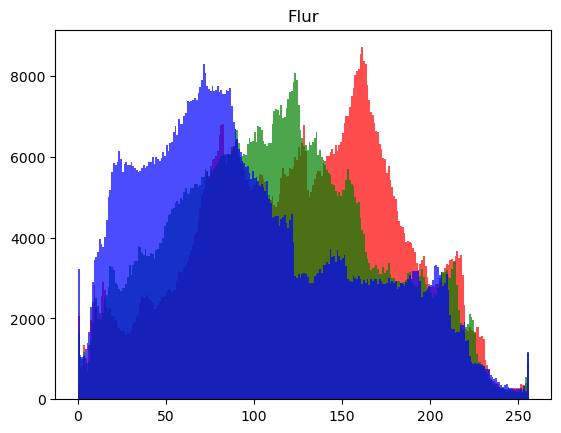

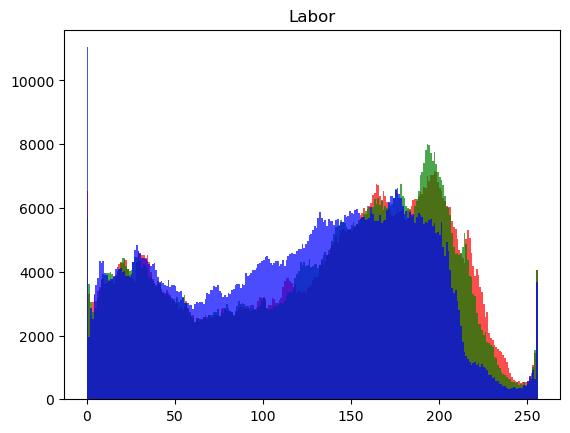

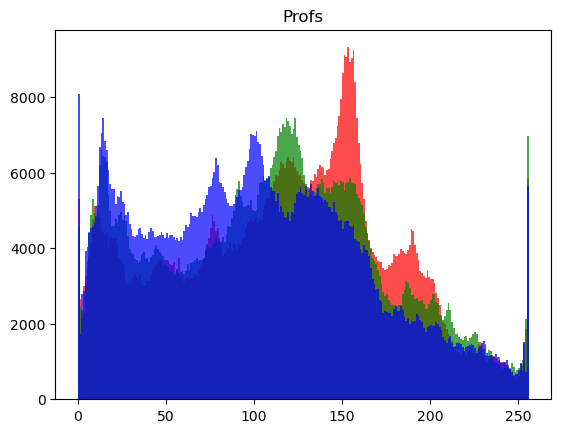

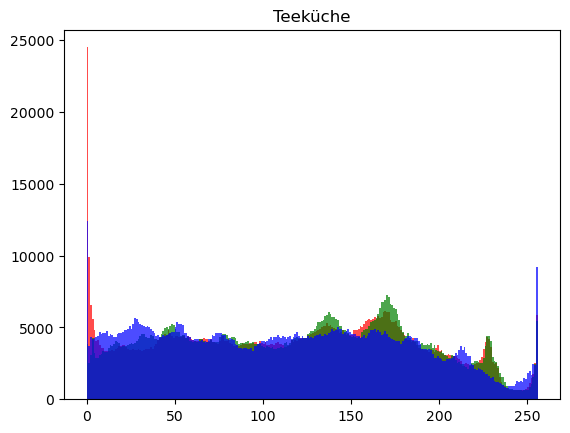

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def picture_to_rgb(directory): # Splitted Bild in Farbkanäle und returned dessen Werte
    image = Image.open(directory)
    data = np.array(image)
    red, green, blue = data[:,:,0], data[:,:,1], data[:,:,2]
    red = red.flatten()
    green = green.flatten()
    blue = blue.flatten()
    return red, green, blue

def draw_histo(data, name): # Printed das Histogramm der einzelnen Räume
    plt.title(name)
    plt.hist(data[0], color='red', alpha=0.7, bins=256, range=[0,256])
    plt.hist(data[1], color='green', alpha=0.7, bins=256, range=[0,256])
    plt.hist(data[2], color='blue', alpha=0.7, bins=256, range=[0,256])
    plt.show()

# Splitted die Trainingsdaten nochmal nach Räumen auf, damit mehrere Histogramme ausgegeben werden können    
flur = [i for i, x in enumerate(training_label_list) if x == "Flur"]
labor = [i for i, x in enumerate(training_label_list) if x == "Labor"]
professorenbuero = [i for i, x in enumerate(training_label_list) if x == "Professorenbuero"]
teekueche = [i for i, x in enumerate(training_label_list) if x == "Teekueche"]
room_names = ["Flur", "Labor", "Profs", "Teeküche"]
room_directory_collection = [flur, labor, professorenbuero, teekueche]

# Iteriert durch die Räume einmal durch, speichert die RGB Werte & gibt sie abschließend als Histogramm aus.
i = 0
for name in room_names:
    data = [[],[],[]]
    for picture_index in room_directory_collection[i]:
        red, green, blue = picture_to_rgb(training_path_list[picture_index])
        data[0].extend(red)
        data[1].extend(green)
        data[2].extend(blue)
    draw_histo(data, name)
    i = i+1

## Teilaufgabe c): Training und Test mit Random Forest 

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

training_data = []
test_data = []

# Speichert die Test & Trainingsdaten nochmal als RGB
for file in training_path_list:
    red, green, blue = picture_to_rgb(file)
    training_data.append(np.concatenate([red, green, blue]))
    
for file in test_path_list:
    red, green, blue = picture_to_rgb(file)
    test_data.append(np.concatenate([red, green, blue]))

# Training mit den RGB Daten im Random Forest
forest = RandomForestClassifier(n_estimators=100)
forest.fit(training_data, training_label_list)

# Erfolg des Trainings wird anhand der Testdaten überprüft
prediction = forest.predict(test_data)
print("Accuracy - ", accuracy_score(test_label_list, prediction))
print("F1-Score - ", f1_score(test_label_list, prediction, average='macro')) # Könnte auch weighted sein, Macro liefert aber bessere Ergebnisse
print("Recall - ", recall_score(test_label_list, prediction, average='macro'))
print("Precision - ", precision_score(test_label_list, prediction, average='macro'))
matrix = confusion_matrix(test_label_list, prediction, labels = ["Flur", "Labor", "Professorenbuero", "Teekueche"]) # Matrix
print(matrix)

Accuracy -  0.55
F1-Score -  0.46503496503496505
Recall -  0.55
Precision -  0.40625000000000006
[[5 0 0 0]
 [0 5 0 0]
 [1 3 1 0]
 [0 0 5 0]]


C:\Users\bmann\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Teilaufgabe d): Hyperparameteroptimierung

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Finde den besten Wert der drei, um die Tiefe des Forests zu beschneiden
param_grid = {'max_depth': [30, 50, 70]} # Bei diesen Werten klassifiziert er den 4ten Raum leicht besser, aber 2 schlechter.
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5) # 5 Folds

# Training und Ausgabe
grid_search.fit(training_data, training_label_list)
print("Beste Hyperparameter: ", grid_search.best_params_)
forest = RandomForestClassifier(n_estimators=grid_search.best_params_['max_depth'])

# Das neue Modell mit den Trainingsdaten trainieren
forest.fit(training_data, training_label_list)

# Erfolg des Trainings wird anhand der Testdaten überprüft
prediction = forest.predict(test_data) # Diesmal mit dem neuen Kriterium
print("Accuracy - ", accuracy_score(test_label_list, prediction))
print("F1-Score - ", f1_score(test_label_list, prediction, average='macro')) # Könnte auch weighted sein, Macro liefert aber bessere Ergebnisse
print("Recall - ", recall_score(test_label_list, prediction, average='macro'))
print("Precision - ", precision_score(test_label_list, prediction, average='macro'))
matrix = confusion_matrix(test_label_list, prediction, labels = ["Flur", "Labor", "Professorenbuero", "Teekueche"]) # Matrix
print(matrix)

Beste Hyperparameter:  {'max_depth': 30}
Accuracy -  0.55
F1-Score -  0.486013986013986
Recall -  0.55
Precision -  0.4375
[[5 0 0 0]
 [0 4 1 0]
 [1 2 2 0]
 [0 0 5 0]]


C:\Users\bmann\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Teilaufgabe e): Dimensionalitätsreduktion

In [41]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# PCA auf Trainingsdaten anwenden und Varianz einstellen. Bei 0.85 bisher beste Leistung
pca = PCA(n_components=0.85)
pca_training_data = pca.fit_transform(training_data)
forest = RandomForestClassifier(n_estimators=100)
forest.fit(pca_training_data, training_label_list)

# Testdaten anpassen
test_data_pca = pca.transform(test_data)

# Erfolg des Trainings wird anhand der Testdaten überprüft
prediction = forest.predict(test_data_pca) # Diesmal mit dem neuen Kriterium
print("Accuracy - ", accuracy_score(test_label_list, prediction))
print("F1-Score - ", f1_score(test_label_list, prediction, average='macro')) # Könnte auch weighted sein, Macro liefert aber bessere Ergebnisse
print("Recall - ", recall_score(test_label_list, prediction, average='macro'))
print("Precision - ", precision_score(test_label_list, prediction, average='macro'))
matrix = confusion_matrix(test_label_list, prediction, labels = ["Flur", "Labor", "Professorenbuero", "Teekueche"]) # Matrix
print(matrix)

Accuracy -  0.6
F1-Score -  0.5548340548340548
Recall -  0.6000000000000001
Precision -  0.6805555555555556
[[5 0 0 0]
 [0 4 1 0]
 [2 1 2 0]
 [2 1 1 1]]
